In [1]:
from __future__ import division, print_function
import time
import torch.utils.data
import torchvision
from torchvision import transforms, datasets
import argparse
import matplotlib
from Bayes_By_Backprop.model import *
from Bayes_By_Backprop_Local_Reparametrization.model import *

matplotlib.use('Agg')
import matplotlib.pyplot as plt


Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/100, Jtr_KL = 10.166409, Jtr_pred = 1.926458, err = 0.361650,    time: 22.861059 seconds

    Jdev = 0.424566, err = 0.120000

best test error
Writting bbb/theta_best.dat

it 1/100, Jtr_KL = 9.105092, Jtr_pred = 0.563709, err = 0.159117,    time: 7.928703 seconds

    Jdev = 0.324547, err = 0.089900

best test error
Writting bbb/theta_best.dat

it 2/100, Jtr_KL = 8.213935, Jtr_pred = 0.468553, err = 0.130550,    time: 8.146134 seconds

    Jdev = 0.273314, err = 0.073400

best test error
Writting bbb/theta_best.dat

it 3/100, Jtr_KL = 7.478907, Jtr_pred = 0.414718, err = 0.116067,    time: 8.166052 seconds

    Jdev = 0.254682, err = 0.071900

best test error
Writting bbb/theta_best.dat

it 4/100, Jtr_KL = 6.875761, Jtr_pred = 0.376852, err = 0.107750,    time: 8.282214 seconds

    Jdev = 0.230029, err = 0.068200

best test error
Writting bbb/theta_best.dat

it 5/100, Jtr_KL = 6.378636,

    Jdev = 0.097237, err = 0.030500

it 46/100, Jtr_KL = 3.821155, Jtr_pred = 0.192635, err = 0.055733,    time: 8.425806 seconds

    Jdev = 0.088831, err = 0.027100

best test error
Writting bbb/theta_best.dat

it 47/100, Jtr_KL = 3.813319, Jtr_pred = 0.193638, err = 0.056867,    time: 8.170145 seconds

    Jdev = 0.096276, err = 0.031100

it 48/100, Jtr_KL = 3.805074, Jtr_pred = 0.191524, err = 0.056350,    time: 8.126693 seconds

    Jdev = 0.089048, err = 0.027600

it 49/100, Jtr_KL = 3.796826, Jtr_pred = 0.187266, err = 0.054450,    time: 7.907090 seconds

    Jdev = 0.102581, err = 0.031700

it 50/100, Jtr_KL = 3.788303, Jtr_pred = 0.189231, err = 0.055717,    time: 8.306877 seconds

    Jdev = 0.094987, err = 0.029700

it 51/100, Jtr_KL = 3.780498, Jtr_pred = 0.187284, err = 0.054617,    time: 7.800674 seconds

    Jdev = 0.105023, err = 0.033700

it 52/100, Jtr_KL = 3.772824, Jtr_pred = 0.187630, err = 0.054917,    time: 8.560981 seconds

    Jdev = 0.090156, err = 0.028100

i

   average time: 8.882693 seconds

Writting bbb/theta_last.dat


RESULTS:
  cost_dev: 0.083564 (cost_train 0.170934)
  err_dev: 0.025500
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 8.882693s

snr: 2395210


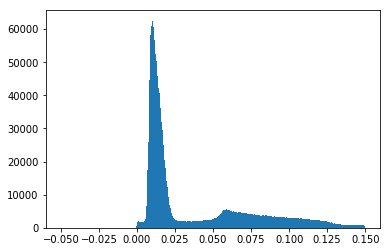

In [20]:
models_dir = 'bbb'
results_dir = 'bbb'

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
batch_size = 128
nb_epochs = 100
log_interval = 1


# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')

lr = 1e-3
nsamples = int(3)  # How many samples to estimate ELBO with at each iteration

# if True: #args.model == 'Local_Reparam':
net = BBP_Bayes_Net_LR(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                 Nbatches=(NTrainPointsMNIST / batch_size), nhid=1200, prior_sig=0.1)#args.prior_sig)


## ---------------------------------------------------------------------------------------------------------------------
# train
epoch = 0
cprint('c', '\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
best_err = np.inf

nb_its_dev = 1

tic0 = time.time()
for i in range(epoch, nb_epochs):
    # We draw more samples on the first epoch in order to ensure convergence
    if i == 0:
        ELBO_samples = 10
    else:
        ELBO_samples = nsamples

    net.set_mode_train(True)
    tic = time.time()
    nb_samples = 0

    for x, y in trainloader:
        cost_dkl, cost_pred, err = net.fit(x, y, samples=ELBO_samples)

        err_train[i] += err
        kl_cost_train[i] += cost_dkl
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    kl_cost_train[i] /= nb_samples  # Normalise by number of samples in order to get comparable number to the -log like
    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_KL = %f, Jtr_pred = %f, err = %f, " % (
    i, nb_epochs, kl_cost_train[i], pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):
            cost, err, probs = net.eval(x, y)  # This takes the expected weights to save time, not proper inference

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir + '/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir + '/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))

## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/KL_cost_train.npy', kl_cost_train)
np.save(results_dir + '/pred_cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)

## ---------------------------------------------------------------------------------------------------------------------
torch.save(net, 'bbb.net')

%matplotlib inline
snr = net.get_weight_SNR()
print('snr:', len(snr))
plt.hist(snr, bins=np.linspace(-0.05, 0.15, 500))
plt.show()

199210


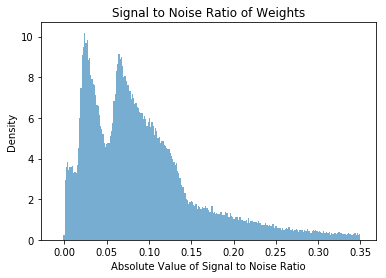

In [4]:
import pickle
pickle.dump(net.get_weight_samples(), open('results/BBBweights.pkl','wb'))

%matplotlib inline
snr = net.get_weight_SNR()

print(len(snr))
plt.title('Signal to Noise Ratio of Weights')
plt.hist(snr, bins=np.linspace(-0.01, 0.35, 250), density=True, alpha=0.6)
plt.ylabel('Density')
plt.xlabel('Absolute Value of Signal to Noise Ratio')
plt.show()

In [21]:

from __future__ import division, print_function
import time
import torch.utils.data
from torchvision import transforms, datasets
import argparse
import matplotlib
from MC_dropout.model import *

matplotlib.use('Agg')
import matplotlib.pyplot as plt



models_dir = 'dropout'
results_dir = 'dropout'

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
batch_size = 128
nb_epochs = 100
log_interval = 1


# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')

lr = 1e-3
########################################################################################

net = MC_drop_net(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                  weight_decay=1, n_hid=1200)

## ---------------------------------------------------------------------------------------------------------------------
# train
epoch = 0
cprint('c', '\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
best_err = np.inf

nb_its_dev = 1

tic0 = time.time()
for i in range(epoch, nb_epochs):

    net.set_mode_train(True)
    tic = time.time()
    nb_samples = 0

    for x, y in trainloader:
        cost_pred, err = net.fit(x, y)

        err_train[i] += err
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_pred = %f, err = %f, " % (i, nb_epochs, pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))


    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):
            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir+'/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir+'/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))

## Save results for plots
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)

## ---------------------------------------------------------------------------------------------------------------------




Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/100, Jtr_pred = 0.329998, err = 0.099750,    time: 2.821560 seconds

    Jdev = 0.201081, err = 0.060200

best test error
Writting dropout/theta_best.dat

it 1/100, Jtr_pred = 0.188278, err = 0.056350,    time: 2.782595 seconds

    Jdev = 0.172069, err = 0.050800

best test error
Writting dropout/theta_best.dat

it 2/100, Jtr_pred = 0.168964, err = 0.049300,    time: 2.786068 seconds

    Jdev = 0.152290, err = 0.042100

best test error
Writting dropout/theta_best.dat

it 3/100, Jtr_pred = 0.164831, err = 0.047517,    time: 2.830179 seconds

    Jdev = 0.153154, err = 0.046900

it 4/100, Jtr_pred = 0.159371, err = 0.044633,    time: 2.735301 seconds

    Jdev = 0.144527, err = 0.041800

best test error
Writting dropout/theta_best.dat

it 5/100, Jtr_pred = 0.157838, err = 0.045050,    time: 2.792760 seconds

    Jdev = 0.144865, err = 0.043500

it 6/100, Jtr_pred = 0.156082, err = 0.0456

it 58/100, Jtr_pred = 0.151731, err = 0.043533,    time: 2.819460 seconds

    Jdev = 0.152191, err = 0.043700

it 59/100, Jtr_pred = 0.152084, err = 0.043317,    time: 2.758585 seconds

    Jdev = 0.144703, err = 0.039000

it 60/100, Jtr_pred = 0.151814, err = 0.043783,    time: 2.808435 seconds

    Jdev = 0.139098, err = 0.039600

it 61/100, Jtr_pred = 0.151155, err = 0.043683,    time: 2.759633 seconds

    Jdev = 0.144968, err = 0.041300

it 62/100, Jtr_pred = 0.152908, err = 0.044350,    time: 2.832317 seconds

    Jdev = 0.159467, err = 0.045600

it 63/100, Jtr_pred = 0.151994, err = 0.043883,    time: 2.740132 seconds

    Jdev = 0.151773, err = 0.043400

it 64/100, Jtr_pred = 0.152152, err = 0.043333,    time: 2.735088 seconds

    Jdev = 0.145927, err = 0.041400

it 65/100, Jtr_pred = 0.151778, err = 0.043600,    time: 2.796052 seconds

    Jdev = 0.154828, err = 0.041100

it 66/100, Jtr_pred = 0.154522, err = 0.043733,    time: 2.784662 seconds

    Jdev = 0.144256, err = 0.

In [6]:
dropout_weights = net.get_weight_samples()
pickle.dump(dropout_weights, open('results/dropoutweights.pkl','wb'))

In [4]:
# FFNN
import torch.nn.functional as F
import torch

class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    # Inherited from the parent class nn.Module
        self.fc1 = torch.nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
#         self.relu = nn.ReLU()                          # Non-Linear ReLU Layer: max(0,x)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size) # 2nd Full-Connected Layer: 500 (hidden node) -> 10 (output class)
        self.fc3 = torch.nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):                              # Forward pass: stacking each layer together
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out
        
nhid = 400
net = Net(784, nhid, 10)
net.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)

In [5]:
num_epochs = 100
batch_size=128

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):   # Load a batch of images with its (index, data, class)
        images = Variable(images.view(-1, 28*28))         # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
        labels = Variable(labels)
        
        optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
        outputs = net(images.cuda())                             # Forward pass: compute the output class given a image
        loss = criterion(outputs, labels.cuda())                 # Compute the loss: difference between the output class and the pre-given label
        loss.backward()                                   # Backward pass: compute the weight
        optimizer.step()                                  # Optimizer: update the weights of hidden nodes
        
        if (i+1) % 100 == 0: # Logging
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, 
                   num_epochs, 
                   i+1, 
                   len(trainset)//batch_size, 
                   loss.data.item()))

Epoch [1/100], Step [100/468], Loss: 0.1897
Epoch [1/100], Step [200/468], Loss: 0.1501
Epoch [1/100], Step [300/468], Loss: 0.0732
Epoch [1/100], Step [400/468], Loss: 0.0961
Epoch [2/100], Step [100/468], Loss: 0.1036
Epoch [2/100], Step [200/468], Loss: 0.0318
Epoch [2/100], Step [300/468], Loss: 0.1398
Epoch [2/100], Step [400/468], Loss: 0.0827
Epoch [3/100], Step [100/468], Loss: 0.1262
Epoch [3/100], Step [200/468], Loss: 0.0540
Epoch [3/100], Step [300/468], Loss: 0.0742
Epoch [3/100], Step [400/468], Loss: 0.0426
Epoch [4/100], Step [100/468], Loss: 0.0422
Epoch [4/100], Step [200/468], Loss: 0.0516
Epoch [4/100], Step [300/468], Loss: 0.0756
Epoch [4/100], Step [400/468], Loss: 0.0574
Epoch [5/100], Step [100/468], Loss: 0.0148
Epoch [5/100], Step [200/468], Loss: 0.0461
Epoch [5/100], Step [300/468], Loss: 0.0055
Epoch [5/100], Step [400/468], Loss: 0.0175
Epoch [6/100], Step [100/468], Loss: 0.0802
Epoch [6/100], Step [200/468], Loss: 0.0495
Epoch [6/100], Step [300/468], L

Epoch [46/100], Step [400/468], Loss: 0.0001
Epoch [47/100], Step [100/468], Loss: 0.0001
Epoch [47/100], Step [200/468], Loss: 0.0001
Epoch [47/100], Step [300/468], Loss: 0.0001
Epoch [47/100], Step [400/468], Loss: 0.0000
Epoch [48/100], Step [100/468], Loss: 0.0000
Epoch [48/100], Step [200/468], Loss: 0.0000
Epoch [48/100], Step [300/468], Loss: 0.0089
Epoch [48/100], Step [400/468], Loss: 0.0016
Epoch [49/100], Step [100/468], Loss: 0.0013
Epoch [49/100], Step [200/468], Loss: 0.0159
Epoch [49/100], Step [300/468], Loss: 0.0000
Epoch [49/100], Step [400/468], Loss: 0.0000
Epoch [50/100], Step [100/468], Loss: 0.0000
Epoch [50/100], Step [200/468], Loss: 0.0469
Epoch [50/100], Step [300/468], Loss: 0.0000
Epoch [50/100], Step [400/468], Loss: 0.0000
Epoch [51/100], Step [100/468], Loss: 0.0000
Epoch [51/100], Step [200/468], Loss: 0.0001
Epoch [51/100], Step [300/468], Loss: 0.0001
Epoch [51/100], Step [400/468], Loss: 0.0001
Epoch [52/100], Step [100/468], Loss: 0.0000
Epoch [52/

Epoch [92/100], Step [300/468], Loss: 0.0000
Epoch [92/100], Step [400/468], Loss: 0.0002
Epoch [93/100], Step [100/468], Loss: 0.0000
Epoch [93/100], Step [200/468], Loss: 0.0001
Epoch [93/100], Step [300/468], Loss: 0.0000
Epoch [93/100], Step [400/468], Loss: 0.0000
Epoch [94/100], Step [100/468], Loss: 0.0000
Epoch [94/100], Step [200/468], Loss: 0.0000
Epoch [94/100], Step [300/468], Loss: 0.0003
Epoch [94/100], Step [400/468], Loss: 0.0000
Epoch [95/100], Step [100/468], Loss: 0.0000
Epoch [95/100], Step [200/468], Loss: 0.0000
Epoch [95/100], Step [300/468], Loss: 0.0000
Epoch [95/100], Step [400/468], Loss: 0.0056
Epoch [96/100], Step [100/468], Loss: 0.0000
Epoch [96/100], Step [200/468], Loss: 0.0000
Epoch [96/100], Step [300/468], Loss: 0.0006
Epoch [96/100], Step [400/468], Loss: 0.0000
Epoch [97/100], Step [100/468], Loss: 0.0618
Epoch [97/100], Step [200/468], Loss: 0.0000
Epoch [97/100], Step [300/468], Loss: 0.0004
Epoch [97/100], Step [400/468], Loss: 0.0000
Epoch [98/

In [6]:
correct = 0
total = 0
for images, labels in valloader:
    images = Variable(images.view(-1, 28*28))
    outputs = net(images.cuda())
    _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
    total += labels.size(0)                    # Increment the total count
    correct += (predicted == labels.cuda()).sum()     # Increment the correct count
    
print('Accuracy of the network on test images: ', 100 * correct.item() / total)

Accuracy of the network on test images:  98.12


In [8]:
# Dropout
import torch.nn.functional as F
import torch

class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    # Inherited from the parent class nn.Module
        self.fc1 = torch.nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
#         self.relu = nn.ReLU()                          # Non-Linear ReLU Layer: max(0,x)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size) # 2nd Full-Connected Layer: 500 (hidden node) -> 10 (output class)
        self.fc3 = torch.nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):                              # Forward pass: stacking each layer together
        out = self.fc1(x)
        out = F.relu(out)
#         out = F.dropout(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = F.dropout(out)
        out = self.fc3(out)
        return out
        
nhid = 800
net = Net(784, nhid, 10)
net.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

##############################################################################
num_epochs = 100
batch_size=128

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):   # Load a batch of images with its (index, data, class)
        images = Variable(images.view(-1, 28*28))         # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
        labels = Variable(labels)
        
        optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
        outputs = net(images.cuda())                             # Forward pass: compute the output class given a image
        loss = criterion(outputs, labels.cuda())                 # Compute the loss: difference between the output class and the pre-given label
        loss.backward()                                   # Backward pass: compute the weight
        optimizer.step()                                  # Optimizer: update the weights of hidden nodes
        
        if (i+1) % 100 == 0: # Logging
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, 
                   num_epochs, 
                   i+1, 
                   len(trainset)//batch_size, 
                   loss.data.item()))
            
#######################################

correct = 0
total = 0
for images, labels in valloader:
    images = Variable(images.view(-1, 28*28))
    outputs = net(images.cuda())
    _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
    total += labels.size(0)                    # Increment the total count
    correct += (predicted == labels.cuda()).sum()     # Increment the correct count
    
print('Accuracy of the network on test images: ', 100 * correct.item() / total)

Epoch [1/100], Step [100/468], Loss: 0.2702
Epoch [1/100], Step [200/468], Loss: 0.2146
Epoch [1/100], Step [300/468], Loss: 0.1158
Epoch [1/100], Step [400/468], Loss: 0.0927
Epoch [2/100], Step [100/468], Loss: 0.0844
Epoch [2/100], Step [200/468], Loss: 0.0471
Epoch [2/100], Step [300/468], Loss: 0.0703
Epoch [2/100], Step [400/468], Loss: 0.0861
Epoch [3/100], Step [100/468], Loss: 0.0130
Epoch [3/100], Step [200/468], Loss: 0.0142
Epoch [3/100], Step [300/468], Loss: 0.0696
Epoch [3/100], Step [400/468], Loss: 0.1232
Epoch [4/100], Step [100/468], Loss: 0.0157
Epoch [4/100], Step [200/468], Loss: 0.0827
Epoch [4/100], Step [300/468], Loss: 0.0591
Epoch [4/100], Step [400/468], Loss: 0.0947
Epoch [5/100], Step [100/468], Loss: 0.0157
Epoch [5/100], Step [200/468], Loss: 0.0060
Epoch [5/100], Step [300/468], Loss: 0.0142
Epoch [5/100], Step [400/468], Loss: 0.0336
Epoch [6/100], Step [100/468], Loss: 0.0049
Epoch [6/100], Step [200/468], Loss: 0.0296
Epoch [6/100], Step [300/468], L

Epoch [46/100], Step [400/468], Loss: 0.0039
Epoch [47/100], Step [100/468], Loss: 0.0001
Epoch [47/100], Step [200/468], Loss: 0.0209
Epoch [47/100], Step [300/468], Loss: 0.0015
Epoch [47/100], Step [400/468], Loss: 0.0124
Epoch [48/100], Step [100/468], Loss: 0.0481
Epoch [48/100], Step [200/468], Loss: 0.0099
Epoch [48/100], Step [300/468], Loss: 0.0101
Epoch [48/100], Step [400/468], Loss: 0.0004
Epoch [49/100], Step [100/468], Loss: 0.0000
Epoch [49/100], Step [200/468], Loss: 0.1303
Epoch [49/100], Step [300/468], Loss: 0.0249
Epoch [49/100], Step [400/468], Loss: 0.0000
Epoch [50/100], Step [100/468], Loss: 0.0000
Epoch [50/100], Step [200/468], Loss: 0.0000
Epoch [50/100], Step [300/468], Loss: 0.0001
Epoch [50/100], Step [400/468], Loss: 0.0000
Epoch [51/100], Step [100/468], Loss: 0.0000
Epoch [51/100], Step [200/468], Loss: 0.0000
Epoch [51/100], Step [300/468], Loss: 0.0072
Epoch [51/100], Step [400/468], Loss: 0.0004
Epoch [52/100], Step [100/468], Loss: 0.0000
Epoch [52/

Epoch [92/100], Step [300/468], Loss: 0.0002
Epoch [92/100], Step [400/468], Loss: 0.0044
Epoch [93/100], Step [100/468], Loss: 0.0004
Epoch [93/100], Step [200/468], Loss: 0.0000
Epoch [93/100], Step [300/468], Loss: 0.0000
Epoch [93/100], Step [400/468], Loss: 0.0001
Epoch [94/100], Step [100/468], Loss: 0.0117
Epoch [94/100], Step [200/468], Loss: 0.0000
Epoch [94/100], Step [300/468], Loss: 0.0806
Epoch [94/100], Step [400/468], Loss: 0.0000
Epoch [95/100], Step [100/468], Loss: 0.0000
Epoch [95/100], Step [200/468], Loss: 0.0000
Epoch [95/100], Step [300/468], Loss: 0.0000
Epoch [95/100], Step [400/468], Loss: 0.0000
Epoch [96/100], Step [100/468], Loss: 0.0000
Epoch [96/100], Step [200/468], Loss: 0.0000
Epoch [96/100], Step [300/468], Loss: 0.0001
Epoch [96/100], Step [400/468], Loss: 0.0123
Epoch [97/100], Step [100/468], Loss: 0.0217
Epoch [97/100], Step [200/468], Loss: 0.0001
Epoch [97/100], Step [300/468], Loss: 0.0000
Epoch [97/100], Step [400/468], Loss: 0.0035
Epoch [98/

In [9]:
weights = np.concatenate((net.fc1.weight.cpu().data.reshape(nhid*784), net.fc2.weight.cpu().data.reshape(nhid**2), net.fc3.weight.cpu().data.reshape(nhid*10)))
pickle.dump(weights, open('results/ffnnweights.pkl', 'wb'))

1988000
198800
198800


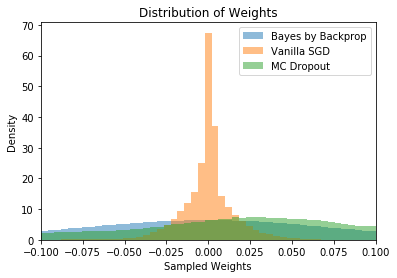

In [11]:
%matplotlib inline
bbb_weights = pickle.load(open('results/BBBweights.pkl', 'rb'))
dropout_weights = pickle.load(open('results/dropoutweights.pkl', 'rb'))
ffnn_weights = pickle.load(open('results/ffnnweights.pkl', 'rb'))

# pickle.dump(bbb_weights, open('BBBweights256.pkl', 'rb'))
# pickle.dump(dropout_weights, open('dropoutweights256.pkl', 'rb'))
# pickle.dump(ffnn_weights, open('SGDweights256.pkl', 'rb'))


print(len(bbb_weights))
print(len(dropout_weights))
print(len(ffnn_weights))

# dropout_weights = net.get_weight_samples()

plt.hist(bbb_weights, density=True, bins=np.linspace(-0.1, 0.1, 50), alpha=0.5, label='Bayes by Backprop')
plt.hist(dropout_weights, density=True, bins=np.linspace(-0.1, 0.1, 50), alpha=0.5, label='Vanilla SGD')
plt.hist(ffnn_weights, density=True, bins=np.linspace(-0.1, 0.1, 50), alpha=0.5, label='MC Dropout')
plt.legend()
plt.xlim((-0.1, 0.1))
plt.ylabel('Density')
plt.xlabel('Sampled Weights')
plt.title('Distribution of Weights')


plt.show()

In [12]:
# pickle.dump(bbb_weights, open('BBBweights1200.pkl', 'wb'))
# pickle.dump(dropout_weights, open('dropoutweights1200.pkl', 'wb'))
# pickle.dump(ffnn_weights, open('SGDweights1200.pkl', 'wb'))

[0, 0.5, 0.75, 0.95, 0.98]
-inf
params: 199210
Delete proportion: 0.000000
    Jtest = 0.107873, err = 0.025000

-10.731100 dB
params: 99605
Delete proportion: 0.500000
    Jtest = 0.099280, err = 0.024700

-8.541501 dB
params: 49803
Delete proportion: 0.750000
    Jtest = 0.096376, err = 0.024700

-2.043322 dB
params: 9961
Delete proportion: 0.950000
    Jtest = 0.103565, err = 0.028500

0.739247 dB
params: 3985
Delete proportion: 0.980000
    Jtest = 0.188387, err = 0.050000



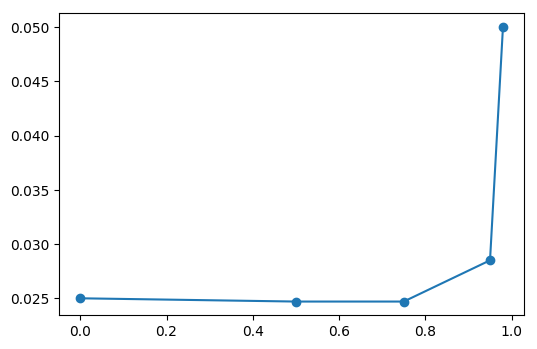

In [13]:
# create pruning graphs
net = torch.load('bbb.net')
SNR_vector = net.get_weight_SNR()

delete_proportions = [0, 0.5, 0.75, 0.95, 0.98]
# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)
# keep_proportions = 1 - delete_proportions


batch_size = 256
Nsamples_predict = 100
# Nsamples_KLD = 20
use_cuda = torch.cuda.is_available()
net.set_mode_train(False)

if use_cuda:
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

else:
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=4)
err_vec = np.zeros(len(delete_proportions))

print(delete_proportions)

for idx, p in enumerate(delete_proportions):
    if p > 0:
        min_snr = np.percentile(SNR_vector, p*100)
        print('%f dB' % (10*np.log10(min_snr)))
        og_state_dict, n_unmask = net.mask_model(Nsamples=0, thresh=min_snr)
#         print(net.model.state_dict()) # for debug purposes
        print('params: %d' % (n_unmask))
    else:
        print('-inf')
        print('params: %d' % (net.get_nb_parameters()/2))
    
    test_cost = 0  # Note that these are per sample
    test_err = 0
    nb_samples = 0
    for j, (x, y) in enumerate(valloader):
        cost, err, probs = net.sample_eval(x, y, Nsamples_predict, logits=False) # , logits=True

        test_cost += cost
        test_err += err.cpu().numpy()
#         test_predictions[nb_samples:nb_samples+len(x), :] = probs.numpy()
        nb_samples += len(x)

    test_cost /= nb_samples
    test_err /= nb_samples

    print('Delete proportion: %f' % (p))
    cprint('b', '    Jtest = %1.6f, err = %1.6f\n' % (test_cost, test_err))
    err_vec[idx] = test_err
    
    if p > 0:
        net.model.load_state_dict(og_state_dict)
    
    
plt.figure(dpi=100)
plt.plot(delete_proportions, err_vec, 'o-')